#summarize indicator values for each ZCTA in the study area: find T stops within zip code area
tpoints_clipped = gpd.clip(joined_data, brook_proj, keep_geom_type=True)Fina Short UEP239 Final Project

## Introduction

In this project I will execute a suitability analysis determining the most suitable ZIP Code Tabulation Area (ZCTA) for recent college graduates to move to. The project focuses on the Boston Metropolitan Area as defined by the boundary of the Boston Region Metropolitan Planning Organization (MPO). The analysis will use the following  indicators to calculate suitability for this demographic:

** Mean housing price/rent payment (where 5=most suitable=lowest rent)
** Age distribution of neighborhood population** (where age closest to 22 and then older from there is best)
** Population density** (where 5=densest = best; we want to replicate a college atmosphere!)
** Euclidean proximity to bus stops **
** Euclidean proximity to train stops **
** Euclidean proximity to farmers markets **


In [83]:
#Import dependencies
import rasterio
from rasterio.plot import show
from rasterio import features

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

import richdem as rd
from scipy import ndimage
from rasterstats import zonal_stats
from shapely.geometry import box

<AxesSubplot:>

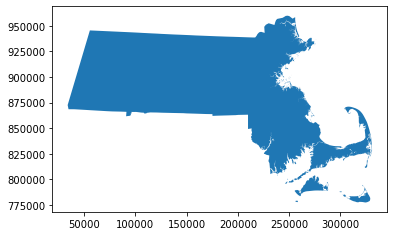

In [67]:
#Use the provided MA outline with detailed coastline OUTLINE25K_POLY.shp to clip the ZCTAs shapefile tl_2010_25_zcta510.shp into the more detailed outline. 
#This will remove the parts of the coastal ZCTAs that extend into the ocean, allowing for a better match with the Boston Region MPO boundary and making your maps more beautiful. 
#This can easily be done using the clip() function from GeoPandas.

#importing a MA outline with detailed coastline
outline25k= gpd.read_file("\\Users\\finas\\Documents\\my work\\School work\\Tufts GRAD\\Spring 2021\\UEP239\\uep239-final-project\\project_data\\OUTLINE25K_POLY\\OUTLINE25K_POLY.shp")
outline25k.plot()
#Extract the outline of the Boston Region MPO from the MPO boundaries shapefile. (This can be easily done using plain old Pandas boolean indexing.)

#Extract all the ZCTAs whose centroid is within the Boston Region MPO boundary.

Importing ZCTA data

<AxesSubplot:>

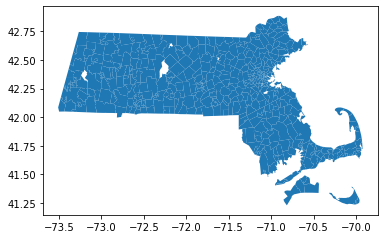

In [11]:
zcta= gpd.read_file("\\Users\\finas\\Documents\\my work\\School work\\Tufts GRAD\\Spring 2021\\UEP239\\uep239-final-project\\project_data\\tl_2010_25_zcta510\\tl_2010_25_zcta510.shp")
zcta.plot()

In [72]:
#now clip the ZCTAs shapefile into the more detailed outline
#must have the same CRS to be clipped so we need to transform both to PSG:6491, NAD83 (2011) / Massachusetts Mainland 
zcta_proj = zcta.to_crs("EPSG:6491")
outline25k_proj = outline25k.to_crs("EPSG:6491")
#check to ensure the same CRS now
zcta_proj.crs == outline25k_proj.crs

True

In [73]:
#clip ZCTA into more detailed outline
zctas_clipped = gpd.clip(zcta_proj, outline25k_proj)
zctas_clipped

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry
0,25,02536,2502536,B5,G6350,S,71696166,9066635,+41.5969756,-070.5678768,N,"MULTIPOLYGON (((275688.314 812598.785, 275674...."
1,25,02556,2502556,B5,G6350,S,10034104,1164445,+41.6394454,-070.6245149,N,"MULTIPOLYGON (((272816.173 818906.998, 272692...."
2,25,02540,2502540,B5,G6350,S,27746696,4550024,+41.5741900,-070.6282848,N,"MULTIPOLYGON (((273126.263 818856.200, 273125...."
3,25,02646,2502646,B5,G6350,S,7798581,801405,+41.6705961,-070.0714493,N,"MULTIPOLYGON (((318348.040 826281.410, 318355...."
4,25,01237,2501237,B5,G6350,S,160121626,1140685,+42.5478177,-073.2680327,N,"POLYGON ((57310.861 917322.668, 57280.413 9173..."
...,...,...,...,...,...,...,...,...,...,...,...,...
533,25,01537,2501537,B5,G6350,S,18085937,295745,+42.1589660,-071.8970514,N,"POLYGON ((167131.394 882124.787, 167132.834 88..."
534,25,01503,2501503,B5,G6350,S,33598202,523984,+42.3849290,-071.6338895,N,"POLYGON ((192620.359 903410.285, 192571.893 90..."
535,25,01452,2501452,B5,G6350,S,106373488,2406515,+42.4895983,-072.0028783,N,"POLYGON ((155270.303 910753.057, 155048.771 91..."
536,25,01571,2501571,B5,G6350,S,53915863,2717076,+42.0537777,-071.9350751,N,"POLYGON ((162378.916 864062.624, 162368.069 86..."


Now we will import a shapefile so we can focus analysis on the Boston Metropolitan Area as defined by the boundary of the Boston Region Metropolitan Planning Organization (MPO).

In [75]:
mpo= gpd.read_file("\\Users\\finas\\Documents\\my work\\School work\\Tufts GRAD\\Spring 2021\\UEP239\\uep239-final-project\\project_data\\MPO_Boundaries\\MPO_Boundaries.shp")
#first things first check coordinate system
mpo.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [76]:
#change to PSG:6491, NAD83 (2011) / Massachusetts Mainland 
mpo = mpo.to_crs("EPSG:6491")
mpo.crs

<Projected CRS: EPSG:6491>
Name: NAD83(2011) / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [87]:
mpo

,OBJECTID,MPO,created_us,created_da,last_edite,last_edi_1,GlobalID,ShapeSTAre,ShapeSTLen,geometry
0,2,Berkshire,None,1970-01-01,None,1970-01-01,{08FDA544-18B0-412A-B442-287E53E987F7},2.451015e+09,2.471530e+05,"POLYGON ((75297.467 944507.570, 75164.096 9402..."
1,3,Cape Cod,None,1970-01-01,None,1970-01-01,{B6CD90CF-2F7D-43F2-B251-FA7F8E00EF01},1.067067e+09,1.288227e+06,"MULTIPOLYGON (((308049.303 871047.644, 308304...."
2,4,Central Massachusetts,None,1970-01-01,None,1970-01-01,{CC777E14-53C8-42AD-B421-71444DA0BB60},2.487546e+09,2.683265e+05,"POLYGON ((186779.189 907537.287, 189264.499 90..."
3,5,Franklin,None,1970-01-01,None,1970-01-01,{4804E708-6B89-4A85-9383-BD91F7589981},1.876456e+09,2.527017e+05,"POLYGON ((135863.148 941517.062, 136724.178 93..."
4,6,Montachusett,None,1970-01-01,None,1970-01-01,{F315DA63-C9CF-40EE-8AA7-5ABA2E1FD528},1.772355e+09,2.748684e+05,"POLYGON ((187559.568 939371.443, 187648.538 93..."
5,7,Martha's Vineyard,None,1970-01-01,None,1970-01-01,{84077DC9-D5D1-471D-9A64-1E5748F80B92},2.757449e+08,3.701721e+05,"MULTIPOLYGON (((274929.860 804010.450, 274934...."
6,8,Merrimack Valley,None,1970-01-01,None,1970-01-01,{C09CD5BA-4FE1-45DD-838E-19F2ECF618DB},7.188680e+08,3.847121e+05,"MULTIPOLYGON (((250194.919 959316.289, 253308...."
7,9,Northern Middlesex,None,1970-01-01,None,1970-01-01,{5B2D231C-F8EB-4768-AB7F-F9D02B3EDBBD},5.073539e+08,1.410283e+05,"POLYGON ((227503.146 927549.973, 226658.886 92..."
8,10,Nantucket,None,1970-01-01,None,1970-01-01,{633A0B7F-266B-4F07-AA30-EC320231ADAA},1.266795e+08,1.680333e+05,"MULTIPOLYGON (((321912.499 794150.950, 321937...."
9,11,Pioneer Valley,None,1970-01-01,None,1970-01-01,{B01F3417-DC74-4561-AE49-935ACC6EF1FF},3.054352e+09,3.206858e+05,"POLYGON ((132905.799 899564.644, 132929.959 89..."


In [90]:
#extract boston region from MPO, using centroid within 
zcta_boston = zcta[zcta.centroid.within(mpo['geometry'][10])]

<AxesSubplot:>

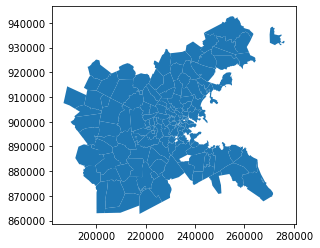

In [92]:
zcta_boston.plot()

Data for Demographic & Social Indicators

In [98]:
#indicator for age and sex, csv format
census= pd.read_csv("\\Users\\finas\\Documents\\my work\\School work\\Tufts GRAD\\Spring 2021\\UEP239\\uep239-final-project\\project_data\\ACSST5Y2019.S0101\\ACSST5Y2019.S0101_data_with_overlays.csv")
census

,GEO_ID,NAME,S0101_C01_001E,S0101_C01_001M,S0101_C01_002E,S0101_C01_002M,S0101_C01_003E,S0101_C01_003M,S0101_C01_004E,S0101_C01_004M,...,S0101_C06_034E,S0101_C06_034M,S0101_C06_035E,S0101_C06_035M,S0101_C06_036E,S0101_C06_036M,S0101_C06_037E,S0101_C06_037M,S0101_C06_038E,S0101_C06_038M
0,id,Geographic Area Name,Estimate!!Total!!Total population,Margin of Error!!Total!!Total population,Estimate!!Total!!Total population!!AGE!!Under ...,Margin of Error!!Total!!Total population!!AGE!...,Estimate!!Total!!Total population!!AGE!!5 to 9...,Margin of Error!!Total!!Total population!!AGE!...,Estimate!!Total!!Total population!!AGE!!10 to ...,Margin of Error!!Total!!Total population!!AGE!...,...,Estimate!!Percent Female!!Total population!!SU...,Margin of Error!!Percent Female!!Total populat...,Estimate!!Percent Female!!Total population!!SU...,Margin of Error!!Percent Female!!Total populat...,Estimate!!Percent Female!!Total population!!SU...,Margin of Error!!Percent Female!!Total populat...,Estimate!!Percent Female!!Total population!!PE...,Margin of Error!!Percent Female!!Total populat...,Estimate!!Percent Female!!Total population!!PE...,Margin of Error!!Percent Female!!Total populat...
1,8600000US01001,ZCTA5 01001,17312,735,956,233,863,222,967,274,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
2,8600000US01002,ZCTA5 01002,30014,485,872,143,1043,192,1123,215,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
3,8600000US01003,ZCTA5 01003,11357,477,0,19,0,19,0,19,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
4,8600000US01005,ZCTA5 01005,5128,404,127,72,199,139,408,153,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,8600000US02777,ZCTA5 02777,16567,23,565,178,968,213,1004,158,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
534,8600000US02779,ZCTA5 02779,6730,20,263,113,554,234,434,139,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
535,8600000US02780,ZCTA5 02780,50438,654,3022,439,2839,402,3605,486,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
536,8600000US02790,ZCTA5 02790,15793,225,573,231,747,236,730,210,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)


In [8]:
#read in bus stops file
buspoints= gpd.read_file("\\Users\\finas\\Documents\\my work\\School work\\Tufts GRAD\\Spring 2021\\UEP239\\uep239-final-project\\project_data\\MBTA_Bus_Stops\\MBTA_Bus_Stops.shp")
buspoints.head(8)

,OBJECTID,STOP_ID,STOP_NAME,TOWN,TOWN_ID,geometry
0,1,3077,Gallivan Blvd @ opp Marsh St,BOSTON,35,POINT (237120.669 892643.408)
1,2,841,Lagrange St @ Virgil Rd,BOSTON,35,POINT (227915.195 892644.017)
2,3,446,Norfolk St @ Nelson St,BOSTON,35,POINT (234385.661 892644.944)
3,4,847,Lagrange St opp Virgil St,BOSTON,35,POINT (227912.601 892650.156)
4,5,3079,Adams St @ Minot St,BOSTON,35,POINT (236644.812 892651.990)
5,6,8687,Adams St @ Minot St,BOSTON,35,POINT (236649.767 892672.199)
6,7,808,Centre St opp Bellevue st,BOSTON,35,POINT (228299.467 892674.321)
7,8,33076,Gallivan Blvd @ Hallet St,BOSTON,35,POINT (237367.877 892703.008)


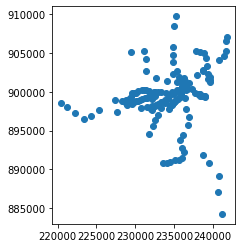

In [112]:
#read in T stops file
tpoints= gpd.read_file("\\Users\\finas\\Documents\\my work\\School work\\Tufts GRAD\\Spring 2021\\UEP239\\uep239-final-project\\project_data\\MBTA_NODE\\MBTA_NODE.shp")
tpoints.head(8)
tpoints.plot()
tpoints = tpoints.to_crs("EPSG:6491")

<AxesSubplot:>

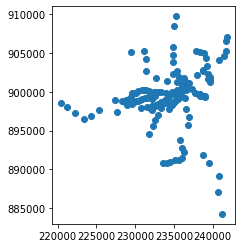

In [118]:
#summarize indicator values for each ZCTA in the study area: find T stops within zip code area
tpoints_clipped = gpd.clip(zcta_boston, tpoints, keep_geom_type=True)
tpoints_clipped.plot()

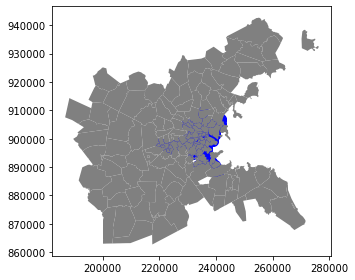

In [136]:
#plotting t points within Boston zip codes
fig, ax = plt.subplots()

tpoints.plot(ax=ax, color='blue', markersize=100);

zcta_boston.plot(ax=ax, facecolor='gray');

plt.tight_layout();

In [132]:
within_zip1 = tpoints.within(zcta_boston['geometry'].iloc[1])
pointsinzip1 = zcta_boston.loc[within_zip1]
pointsinzip1

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [102]:
#Summarize the indicator values (like population density) for each ZCTA in the study area.

#writing a loop that will retain all points that have been found in a Boston zip code polygon 
for point in tpoints:
    for polygon in zcta_boston:
        if point.within(zcta_boston['geometry'].iloc[polygon]):
            

,STATION,LINE,TERMINUS,ROUTE,geometry
0,Ashmont,RED,Y,A - Ashmont C - Alewife,POINT (236007.538 892693.023)
1,Harvard,RED,N,A - Ashmont B - Braintree C - Alewife,POINT (231387.274 902684.016)
2,Kendall/MIT,RED,N,A - Ashmont B - Braintree C - Alewife,POINT (234087.917 901406.551)
3,Capen Street,RED,N,Mattapan Trolley,POINT (234055.438 890869.375)
4,Tufts Medical Center,ORANGE,N,Forest Hills to Oak Grove,POINT (235900.324 899934.313)
...,...,...,...,...,...
161,East Berkeley Street,SILVER,N,SL4 SL5,POINT (235778.434 899384.292)
162,Herald Street,SILVER,N,SL4 SL5,POINT (235865.742 899637.746)
163,Tuffs Medical Center,SILVER,N,SL4 SL5,POINT (235939.100 899996.710)
164,Black Falcon Ave,SILVER,N,SL2,POINT (238957.352 899405.356)


In [104]:
zcta_bostonmask = tpoints.within(zcta_boston.loc[0, 'geometry'])

KeyError: 0

In [109]:
zcta_boston['geometry'[0]]

KeyError: 'g'

In [101]:
#read in farmers markets
markets = gpd.read_file("\\Users\\finas\\Documents\\my work\\School work\\Tufts GRAD\\Spring 2021\\UEP239\\uep239-final-project\\project_data\\FARMERSMARKETS_PT\\FARMERSMARKETS_PT.shp")

In [ ]:
markets_raster = features.rasterize(markets['geometry'], fill=1, default_value=0)

#For each chosen indicator:
#If applicable, visualize any spatial data the indicator is based on. (For example, the locations of certain POIs.)

//Summarize the indicator values (like population density) for each ZCTA in the study area.//


Produce a choropleth map visualizing the indicator values and produce a ZCTA ranking based on the indicator values, reporting the highest and lowest ranking ZCTAs.



#Convert the indicator values into a suitability or vulnerability index or score. This can be done in two ways:


#Reclassify the indicator values based on classes of your choice into a five-point (or ten-point) score.

#Normalize the indicator values into a suitability or vulnerability index ranging from zero to one.